## DistilRoBERTa

In [2]:
# import packages
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
    

In [7]:
# Load data 
train_df = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_df = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_df = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)
data = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

In [4]:
# Load DistilRoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["script"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["script"])  # Remove raw text after tokenization
tokenized_datasets = tokenized_datasets.rename_column("passed_bechdel", "labels")  # Rename for Trainer compatibility
tokenized_datasets.set_format("torch")  # Use PyTorch tensors


Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [ ]:
#tokenizer.save_pretrained("./fine_tuned_distilroberta")

# reload
#tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")
tokenizer = RobertaTokenizer.from_pretrained("./fine_tuned_distilroberta")


In [7]:
# fine-tuning model
# Load RobertaForSequenceClassification with DistilRoBERTa's pre-trained weights
model_name = 'distilroberta'
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)  

results_df = pd.DataFrame(columns=[
    "model", "split", "accuracy", "f1_score", "roc_auc", 
    "true_negatives", "true_positives", "false_positives", "false_negatives", "precision", "recall", 
    "true_negative_rate", "false_negative_rate", "false_positive_rate"])

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)

    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel()

    # ROC-AUC Score 
    roc_auc = roc_auc_score(labels, logits[:, 1])

    # Plot and save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Failed", "Passed"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{model_name}, data split: {datasplit}")
    plt.savefig(f'./output/figures/{model_name}_{datasplit}_confusion_matrix.jpeg')
    #plt.savefig(f"./output/figures/distilroberta_confusion_matrix_epoch_{trainer.state.epoch}.png")
    plt.show()

    # Append results to DataFrame
    results_df.loc[len(results_df)] = {
        "model": model_name, 
        "split": datasplit, # 
        "accuracy": acc,
        "f1_score": f1, 
        "roc_auc": roc_auc,
        "true_negatives": tn, 
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn, 
        "precision": precision, 
        "recall": recall, 
        "true_negative_rate": tn/(tn+fp), 
        "false_negative_rate": fn/(fn+tp), 
        "false_positive_rate": fp/(fp+tn)
    }

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save checkpoint at each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
   # warmup_steps = 500,
    logging_dir="./logs",
    load_best_model_at_end=True,       # Load the best model based on validation accuracy
    metric_for_best_model="f1", #"accuracy",  # Select best model based on validation accuracy
    save_total_limit=2,                 # Save at most 2 checkpoints
    seed = 42
)

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'], #tokenized_datasets["validation"],  # Validation dataset for evaluation
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.521974,0.768362,0.766334,0.778881,0.768362
2,No log,0.517803,0.779661,0.779619,0.780025,0.779661
3,No log,0.503839,0.785311,0.785311,0.785311,0.785311


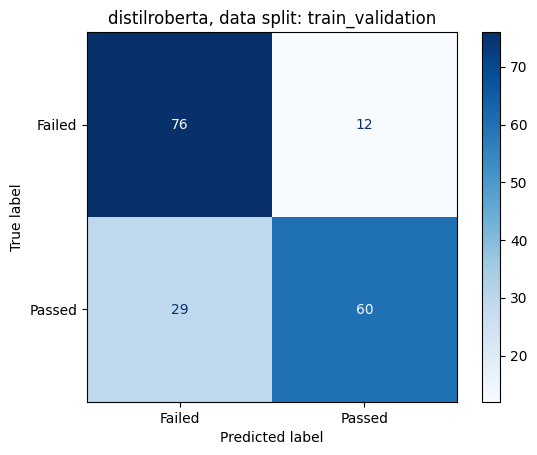

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


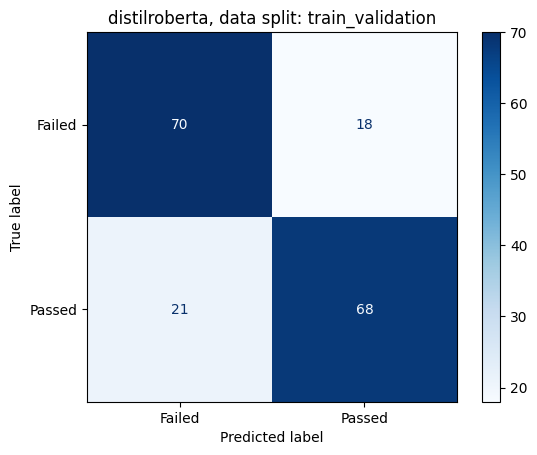

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


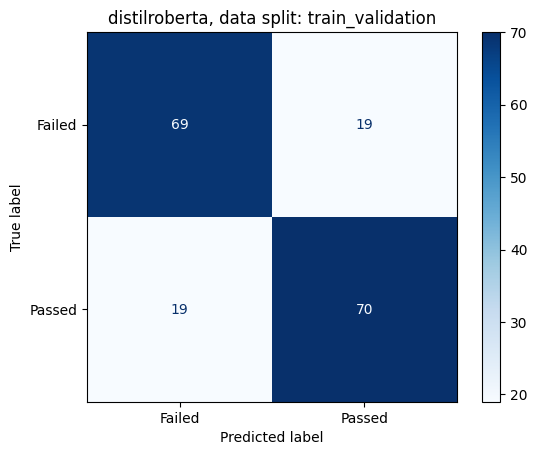

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_validation,0.768362,0.766334,0.820097,76,60,12,29,0.778881,0.768362,0.863636,0.325843,0.136364
1,distilroberta,train_validation,0.779661,0.779619,0.821629,70,68,18,21,0.780025,0.779661,0.795455,0.235955,0.204545
2,distilroberta,train_validation,0.785311,0.785311,0.836951,69,70,19,19,0.785311,0.785311,0.784091,0.213483,0.215909


In [11]:
# Train the model 
datasplit = 'train_validation'
trainer.train()
results_df

In [9]:
# save model
#model.save_pretrained("./fine_tuned_distilroberta")

# reload model
model = RobertaForSequenceClassification.from_pretrained("./fine_tuned_distilroberta")

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


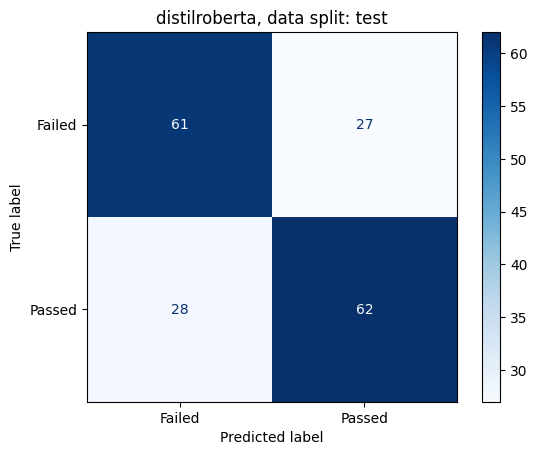


Test Results After Training:


,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_validation,0.768362,0.766334,0.820097,76,60,12,29,0.778881,0.768362,0.863636,0.325843,0.136364
1,distilroberta,train_validation,0.779661,0.779619,0.821629,70,68,18,21,0.780025,0.779661,0.795455,0.235955,0.204545
2,distilroberta,train_validation,0.785311,0.785311,0.836951,69,70,19,19,0.785311,0.785311,0.784091,0.213483,0.215909
3,distilroberta,test,0.691011,0.691021,0.732071,61,62,27,28,0.691074,0.691011,0.693182,0.311111,0.306818


In [13]:
# Explicitly evaluate the model on the test dataset after training
datasplit = "test"
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("\nTest Results After Training:")
test_results
results_df

# Save results

In [ ]:
# adding to the performance df for plotting 

# reload other performances
performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performances_df.csv')

In [ ]:
# concatenate old and new performances
performance_df_distil = pd.concat([performance_df, results_df], ignore_index=True)
performance_df_distil

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.793400,0.786900,0.866432,584,541,121,172,0.817221,0.758766,0.828369,0.241234,0.171631
1,BoW_log_reg,validation,0.779700,0.766500,0.867339,74,64,14,25,0.820513,0.719101,0.840909,0.280899,0.159091
2,BoW_log_reg,test,0.702200,0.682600,0.746338,68,57,20,33,0.740260,0.633333,0.772727,0.366667,0.227273
3,BoW_rf,train,0.778600,0.771100,0.866319,575,529,130,184,0.802731,0.741935,0.815603,0.258065,0.184397
4,BoW_rf,validation,0.762700,0.743900,0.850613,74,61,14,28,0.813333,0.685393,0.840909,0.314607,0.159091
5,BoW_rf,test,0.679800,0.650300,0.739899,68,53,20,37,0.726027,0.588889,0.772727,0.411111,0.227273
6,BoW_svc,train,0.809600,0.786100,0.919259,652,496,53,217,0.903461,0.695652,0.924823,0.304348,0.075177
7,BoW_svc,validation,0.757100,0.715200,0.847612,80,54,8,35,0.870968,0.606742,0.909091,0.393258,0.090909
8,BoW_svc,test,0.713500,0.662300,0.763510,77,50,11,40,0.819672,0.555556,0.875000,0.444444,0.125000
9,tf_idf_log_reg,train,0.770100,0.754900,0.833858,590,502,115,211,0.813614,0.704067,0.836879,0.295933,0.163121


In [4]:
# save 
#performance_df_distil.to_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df_w_distil.csv', index = False)

# reload
performance_df_distil = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df_w_distil.csv')

# Plot model performances

In [ ]:
# make plot! 
# drop first two rows to ease plotting later
#results_df.drop(results_df.head(2).index, inplace = False)
# results_df = results_df.drop(results_df.head(2).index).reset_index(drop=True)
# results_df

In [5]:
# fix value name for easier plotting
performance_df_distil.loc[performance_df_distil['split'] == 'train_validation', 'split'] = 'train'
performance_df_distil

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.784200,0.777000,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.785300,0.771100,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.713500,0.687100,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.803200,0.791900,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.745800,0.723900,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.674200,0.637500,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909
6,BoW_svc,train,0.913300,0.910300,0.975125,671,624,34,89,0.948328,0.875175,0.951773,0.124825,0.048227
7,BoW_svc,validation,0.762700,0.737500,0.846272,76,59,12,30,0.830986,0.662921,0.863636,0.337079,0.136364
8,BoW_svc,test,0.685400,0.650000,0.756881,70,52,18,38,0.742857,0.577778,0.795455,0.422222,0.204545
9,tf_idf_log_reg,train,0.784900,0.771900,0.856647,597,516,108,197,0.826923,0.723703,0.846809,0.276297,0.153191


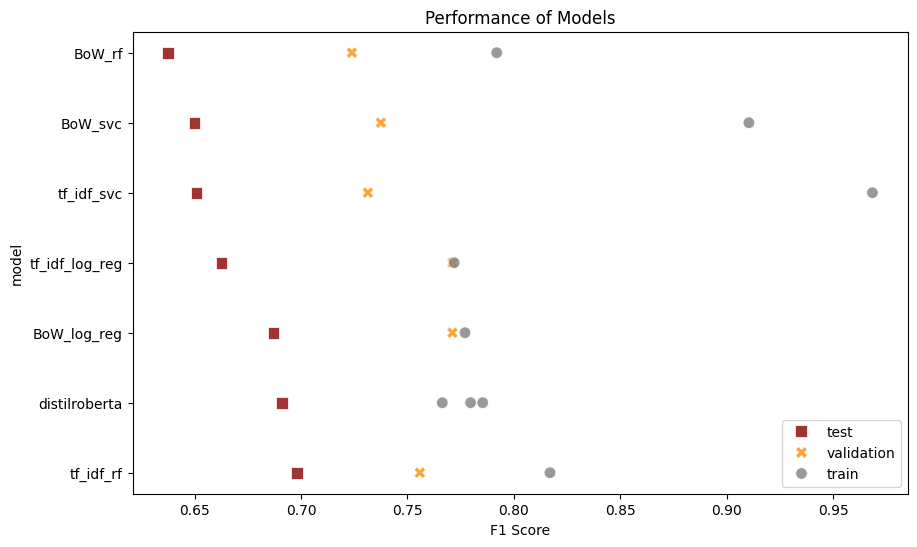

In [ ]:
# make performance plot
# Specify the order of the legend and the icons
order = ['test', 'validation', 'train']
markers = {'test': 's', 'validation': 'X', 'train': 'o'}

# Sort the DataFrame by split and f1_score
performance_df_distil['split_order'] = performance_df_distil['split'].map({v: i for i, v in enumerate(order)})  # Map splits to numeric order
performance_df_sorted = performance_df_distil.sort_values(by=['split_order', 'f1_score'], ascending=[True, True])  # Sort by split order and f1_score

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Make wider to show all points
sns.scatterplot(data=performance_df_sorted, 
                y='model', 
                x='f1_score', 
                style='split',
                hue='split', 
                markers=markers,
                palette=['darkred', 'darkorange', 'grey'],
                hue_order=order, 
                style_order=order, 
                s=70,
                alpha=0.8)

# Customize plot
plt.title("Performance of Models")
plt.xlabel("F1 Score")
plt.legend(loc='lower right')  # Adjust legend position

# Remove temporary column used for sorting
performance_df_distil.drop(columns='split_order', inplace=True)
#plt.savefig('../figures/model_performance_w_distil.jpeg', format='jpeg', dpi=300) 
plt.show()

# Feature importances

need to start new virtul env, see BoW_tf_idf script for a detailed explanation

In [3]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve, average_precision_score, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import pickle as pkl
import shap
print('np version:', np.__version__)

import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

np version: 2.0.0


In [32]:
tokenizer = RobertaTokenizer.from_pretrained("./fine_tuned_distilroberta")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["script"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["script"])  # Remove raw text after tokenization
tokenized_datasets = tokenized_datasets.rename_column("passed_bechdel", "labels")  # Rename for Trainer compatibility
tokenized_datasets.set_format("torch")  # Use PyTorch tensors

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [44]:
tokenized_datasets['validation'][0:5]['input_ids']

tensor([[    0, 13354, 26207,  ...,  4259,    20,     2],
        [    0,  3764,  9298,  ...,    37,  3369,     2],
        [    0,   347,  2336,  ...,    62,    85,     2],
        [    0,  7981,  1941,  ...,     5,  2311,     2],
        [    0, 35163, 32175,  ...,    69,   978,     2]])

In [ ]:
# Load model
#model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

# Function to predict probabilities for SHAP
def predict_probabilities(tokenized_inputs):
    # Ensure the input tensors are on the same device as the model
    inputs = {key: val.to(model.device) for key, val in tokenized_inputs.items()}
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Compute probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probabilities

# Initialize SHAP explainer
# The masker uses the tokenizer since the text is already tokenized
explainer = shap.Explainer(
    model=predict_probabilities,  # The wrapper function for your model
    masker=shap.maskers.Text(tokenizer),  # Use the Hugging Face tokenizer for masking
)

# Sample tokenized inputs from the validation dataset
sample_tokenized_inputs = tokenized_datasets['validation'][0:5]['input_ids']  # Select 5 samples for SHAP

# Compute SHAP values for the sample tokenized inputs
shap_values = explainer(sample_tokenized_inputs)

# Visualize the SHAP explanations
shap.text_plot(shap_values)

# Optionally, save the SHAP explanations
#shap.save_html("./output/shap_explanations.html", shap_values)


In [ ]:

# Load tokenizer and model
#tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")
#model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

# Function to predict probabilities for SHAP
def predict_probabilities(texts):
    # Tokenize the texts
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    
    # Move tensors to the same device as the model (e.g., GPU if available)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Compute probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probabilities

# Initialize SHAP explainer with tokenizer-compatible masking
explainer = shap.Explainer(
    model=predict_probabilities,  # The wrapper function for your model
    masker=shap.maskers.Text(tokenizer),  # Use the Hugging Face tokenizer for masking
)

# Sample texts for explanation (ensure it's already a list of strings)
sample_texts = val_df["script"].sample(5).tolist()  # Directly extract as a list if already valid

# Compute SHAP values for the sample texts
shap_values = explainer(sample_texts)

# Visualize the SHAP explanations
shap.text_plot(shap_values)

# Optionally, save the SHAP explanations
#shap.save_html("./output/shap_explanations.html", shap_values)
